# Plot Map

## Cluster Setting
Dask is a flexible library for parallel computing in Python. 

Dask.distributed is a lightweight library for distributed computing in Python.

The Client is the primary entry point for users of dask.distributed.

In [1]:
## Distributed computing
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster

cluster = KubeCluster() # reads provided yaml file
# cluster.scale_up(10)  # specify number of nodes explicitly
# cluster.adapt(minimum=1, maximum=100)  # or dynamically scale based on current workload
cluster.adapt(maximum=50)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.19.92:33643
distributed.scheduler - INFO -   dashboard at:                     :8787


In [2]:
# Connect to distributed cluster and override default
client = Client(cluster) 
client

distributed.scheduler - INFO - Receive client connection: Client-f8d644a2-3bcd-11ea-8821-aea0f8d0117a
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.19.92:33643 Dashboard: /user/0000-0001-5234-177x/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Environment Setting

The pangeo platform is using an old version xesmf. In order to avoid error, we need to update the xesmf by execute the following code:

(it seems we need to do it every time)

In [ ]:
!pip install --upgrade git+https://github.com/JiaweiZhuang/xESMF.git

In [4]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0' # disabled the __array_function__ protocol
# Some info bout the above protocol can be found on :
# http://blog.christianperone.com/2019/07/numpy-dispatcher-when-numpy-becomes-a-protocol-for-an-ecosystem/

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import gsw # Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10
from tqdm import tqdm # show progress meter
import cartopy.crs as ccrs 
import cartopy
import xesmf as xe

from xhistogram.xarray import histogram

%matplotlib inline
# plt.rcParams['figure.figsize'] = 12, 6
# %config InlineBackend.figure_format = 'retina'  #enabling 2x PNG matplotlib plots in the IPython notebook

In [7]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    except:
        ds = []
        print(model, ": no data")
    return ds        

Fetch the data from 15 models that have biogeochem output.



In [8]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
models = ['CanESM5', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GFDL-CM4',
          'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'IPSL-CM6A-LR', 'MIROC-ES2L',
          'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'UKESM1-0-LL']
var = 'tos'
expe = 'historical'
freq = 'Omon'

xrays = []
for model in tqdm(models):
    xray = get_data(df, var, model, expe, freq)
    xrays.append(xray)
xray_dic = {key:value for key, value in zip(models, xrays)}

 67%|██████▋   | 10/15 [00:09<00:04,  1.13it/s]

MPI-ESM1-2-HR : no data


 93%|█████████▎| 14/15 [00:10<00:00,  1.91it/s]

NorCPM1 : no data
NorESM2-LM : no data


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


### To avoid the error during parallel regridding with dask-distributed, save the result first.

In [ ]:
aves = []

for model in tqdm(models):
    try:
        ds = xray_dic[model].sel(time=slice('1990','2009')).mean(dim='time').tos
        
        if 'latitude' in ds.coords:
            ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
        if 'nav_lat' in ds.coords:
            ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
        ds = ds.load()
        outname = 'mean/' + str(model) + '.nc'
        ds.to_netcdf(outname)
            
    except Exception as E:
        ds = []
        print(model, E)

    aves.append(ds)

ave_dic = {key:value for key, value in zip(models, aves)}

## Regridding

Behzad's code for regridding:

nearest from scipy.interpolate.datagrid
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

Here we use xesmf
https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html


In [5]:
# Create a Global 2D rectilinear grid of 1 degree x 1 degree
ds_out = xe.util.grid_global(1, 1)
ds_out

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [17]:
# Another method for out grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

CanESM5

It is configured on the tripolar ORCA1 C grid with 45 z-coordinate vertical levels, varying in thickness from ∼ 6 m near the surface to ∼ 250 m in the abyssal ocean. 

The horizontal resolution is based on a 1∘ Mercator grid, varying with the cosine of latitude, with a refinement of the meridional grid spacing to 1∕3∘ near the Equator. The adopted model settings include the linear free surface formulation (see Madec and the NEMO team, 2012, and references therein). 

In [9]:
regrids = []
for model in tqdm(models):
    try:
        dsf = 'mean/' + str(model) + '.nc'
        ds = xr.open_dataset(dsf)
        
        dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        dsr_out = dsr(ds)
        dsr.clean_weight_file()
        
        #outname = 'Regrid/' + str(model) + '_reg.nc'
        #dsr_out.to_netcdf(outname)
        
    except Exception as E:
        dsr_out = []
        print(model, E)
    regrids.append(dsr_out)
regrid_dic = {key:value for key, value in zip(models, regrids)}

  0%|          | 0/15 [00:00<?, ?it/s]

Create weight file: bilinear_291x360_180x360_peri.nc


  7%|▋         | 1/15 [00:12<02:55, 12.56s/it]

using dimensions ('j', 'i') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_291x360_180x360_peri.nc
Create weight file: bilinear_384x320_180x360_peri.nc


 13%|█▎        | 2/15 [00:22<02:33, 11.83s/it]

using dimensions ('nlat', 'nlon') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_384x320_180x360_peri.nc
Create weight file: bilinear_180x360_180x360_peri.nc


 20%|██        | 3/15 [00:25<01:49,  9.10s/it]

using dimensions ('lat', 'lon') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_180x360_180x360_peri.nc
Create weight file: bilinear_294x362_180x360_peri.nc


 27%|██▋       | 4/15 [00:36<01:47,  9.79s/it]

using dimensions ('y', 'x') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_294x362_180x360_peri.nc
Create weight file: bilinear_1080x1440_180x360_peri.nc


 33%|███▎      | 5/15 [01:32<03:56, 23.66s/it]

using dimensions ('y', 'x') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_1080x1440_180x360_peri.nc
Create weight file: bilinear_576x720_180x360_peri.nc


 40%|████      | 6/15 [01:56<03:32, 23.66s/it]

using dimensions ('y', 'x') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_576x720_180x360_peri.nc
Create weight file: bilinear_90x144_180x360_peri.nc


 47%|████▋     | 7/15 [01:58<02:18, 17.28s/it]

using dimensions ('lat', 'lon') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_90x144_180x360_peri.nc
Create weight file: bilinear_90x144_180x360_peri.nc


 53%|█████▎    | 8/15 [02:01<01:29, 12.85s/it]

using dimensions ('lat', 'lon') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_90x144_180x360_peri.nc
Create weight file: bilinear_332x362_180x360_peri.nc


 60%|██████    | 9/15 [02:09<01:07, 11.32s/it]

using dimensions ('y', 'x') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_332x362_180x360_peri.nc
Create weight file: bilinear_256x360_180x360_peri.nc


 67%|██████▋   | 10/15 [02:14<00:47,  9.48s/it]

using dimensions ('y', 'x') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_256x360_180x360_peri.nc
MPI-ESM1-2-HR [Errno 2] No such file or directory: b'/home/jovyan/CMIP6-Codes/mean/MPI-ESM1-2-HR.nc'
Create weight file: bilinear_363x360_180x360_peri.nc


 80%|████████  | 12/15 [02:25<00:25,  8.36s/it]

using dimensions ('y', 'x') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_363x360_180x360_peri.nc
NorCPM1 [Errno 2] No such file or directory: b'/home/jovyan/CMIP6-Codes/mean/NorCPM1.nc'
NorESM2-LM [Errno 2] No such file or directory: b'/home/jovyan/CMIP6-Codes/mean/NorESM2-LM.nc'
Create weight file: bilinear_330x360_180x360_peri.nc


100%|██████████| 15/15 [02:34<00:00, 10.27s/it]

using dimensions ('j', 'i') from data variable tos as the horizontal dimensions for this dataset.
Remove file bilinear_330x360_180x360_peri.nc


MPI-ESM1-2-HR  Error:  'list' object has no attribute 'tos'
NorCPM1  Error:  'list' object has no attribute 'tos'
NorESM2-LM  Error:  'list' object has no attribute 'tos'


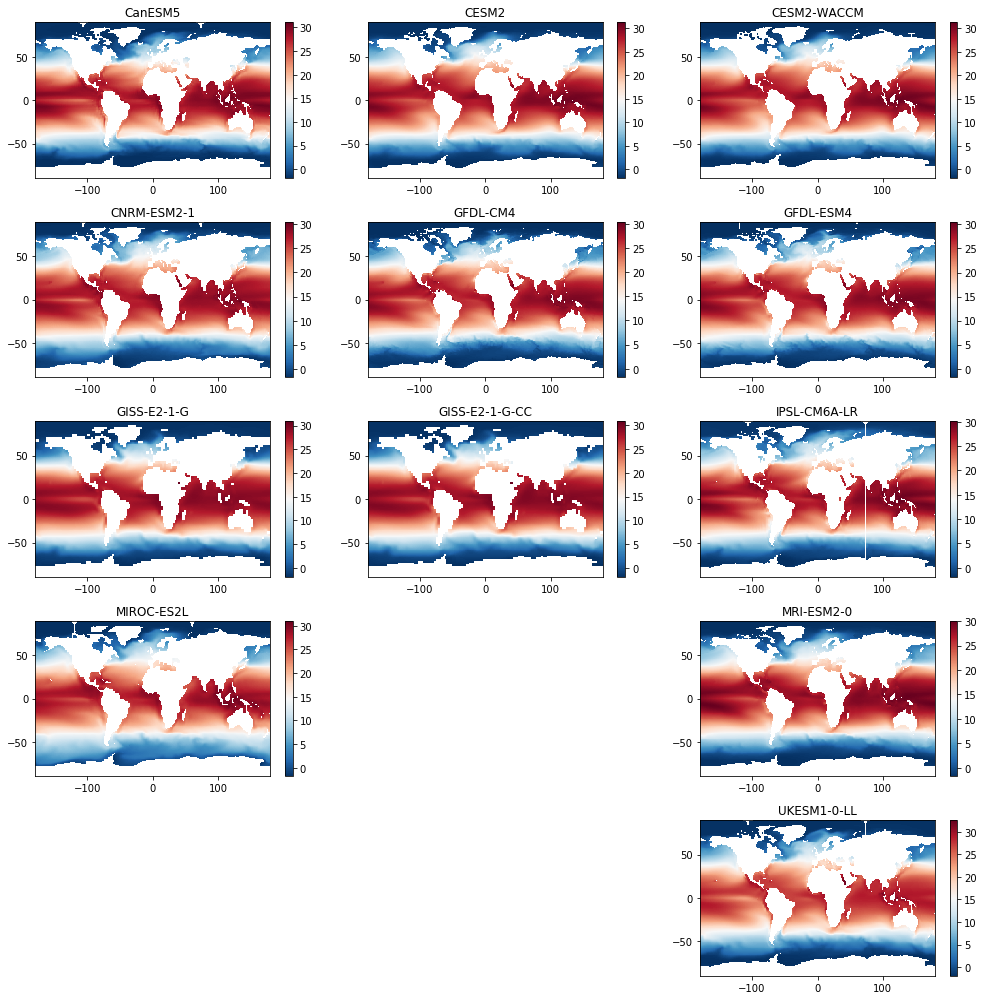

In [27]:
plt.figure(figsize=(14,14))
i = 0
for model in models:  
    i = i + 1
    try:
        data = regrid_dic[model]
        s = data.tos
        
    except Exception as e:
        print(model,' Error: ',e)
        continue
    ax = plt.subplot(5,3,i)
    
    plt.pcolormesh(data.lon, data.lat, s, cmap=plt.cm.RdBu_r)
    plt.colorbar()
    ax.title.set_text(str(model))
    
plt.tight_layout()
plt.savefig('tos.png', dpi=600)